In [7]:
%reload_ext autoreload
%autoreload 2

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from src import const
from src.env.env_basic import WaterLeakEnv


Path.cwd()

PosixPath('/Users/adamzh0u/315_RL/cege_test')

## From data to feature 

In [8]:
df = pd.read_csv(const.PATH_DATA/'simulation'/'Data_water_demand_with_leaks_44_10.txt')

In [114]:
env = WaterLeakEnv(data = df)
# env._next_observation()
# obs, reward, terminated, info = env.step(1)
# reward

## eps_greedy


record dumped to data/train/eps_greedy_record.npy


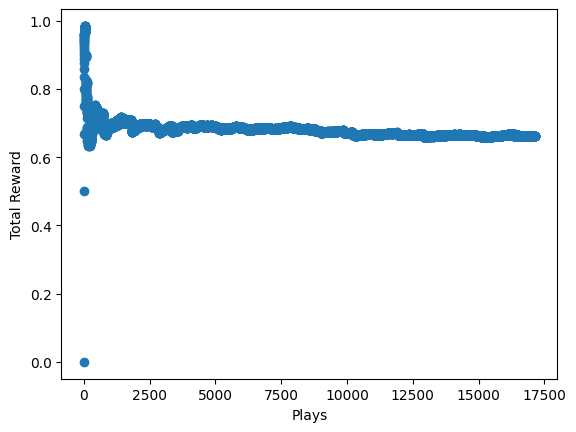

In [47]:
from src.agents.agent_epsgreedy import AgentGreedy

env = WaterLeakEnv(data = df)
agent = AgentGreedy(env)

ls_rewards = agent.run(train=True, eps=0.1)

fig, ax=plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Total Reward")
total_reward = np.cumsum(ls_rewards)
mean_reward = total_reward/np.arange(1,len(total_reward)+1)
ax.scatter(range(len(mean_reward)), mean_reward)

# dqn

In [21]:
import numpy as np
import torch

env = WaterLeakEnv(data = df)

window_size = 10
N, D_in, H, D_out=1, window_size, 100, 2
# N是批大小，D_in是输入维度，H是隐藏维度，D_out是输出维度

model=torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)


epochs=5000
learning_rate=1e-2
cur_state=torch.Tensor(obs[-10:]) # float tensor

In [22]:
def softmax(av, tau=1.12):
    softm=np.exp(av / tau) / np.sum( np.exp(av / tau) )
    return softm

In [25]:
def one_hot(N=2, action, val=1):
    one_hot_vec=np.zeros(N)
    one_hot_vec[action]=val
    return one_hot_vec

-5

In [ ]:
# 负奖励转换为正奖励是一种常见的技术，特别是在使用算法如 DQN 时，因为某些损失函数或算法可能对负值处理不好。
# 通常 Q-learning 算法（包括 DQN）直接选择 Q 值最大的动作。然而，你提到要使用 softmax 将动作转化成向量

array([], dtype=int64)

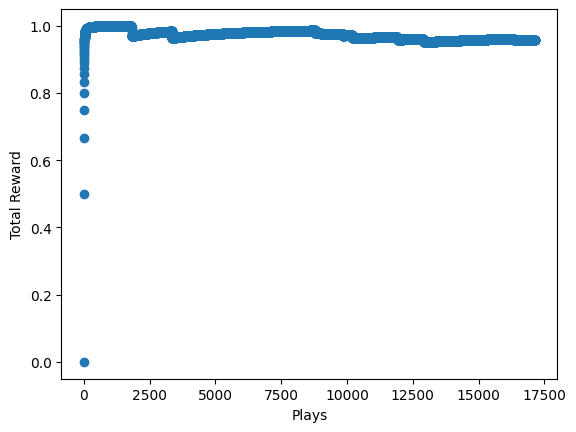

In [51]:
fig, ax=plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Total Reward")
total_reward = np.cumsum(ls_rewards)
mean_reward = total_reward/np.arange(1,len(total_reward)+1)
ax.scatter(range(len(mean_reward)), mean_reward)
# plot index if  >2 in ls_rewards
ls_rewards = np.array(ls_rewards)
ls_rewards[ls_rewards>2]

In [50]:
obs = env.reset()

ls_rewards=[0]
terminated=False
reward_shift = 11
softmax = False
while not terminated:
    # run network to get Q values of each action
    pred_q_value=model(cur_state) 
    if softmax:
        av_softmax=softmax(pred_q_value.data.numpy(), tau=2.0)
        av_softmax /=av_softmax.sum()
        action=np.random.choice([0,1], p=av_softmax)
    else:
        action=np.argmax(pred_q_value.data.numpy())

    # take action and get reward
    obs, reward, terminated, info = env.step(action)
    dqn_reward=reward + reward_shift  # shift to make q values positive

    # 
    target_q_value=pred_q_value.data.numpy().copy()
    target_q_value[action] = dqn_reward
    target_q_value=torch.Tensor(target_q_value)

    # backpropagation
    loss=loss_fn(pred_q_value, target_q_value)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # record rewards
    ls_rewards.append(reward)
    
    # next state
    cur_state=torch.Tensor(obs[-10:])
